In [4]:
import os
os.chdir('/Users/ngdnh/Codespace/PulsatingPulseShop/')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%config InlineBackend.figure_formats = ['svg']

In [5]:
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
import utility as ut
import qutip as qt 
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.stats import norm
from scipy.stats import gaussian_kde

In [6]:
plt.rcParams['axes.linewidth'] = 1.0
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

print(today)

2025-02-01 17:02:01.020530


# Observation of Rabi oscillation on higher subspaces

Everything starts with Rabi oscillation. In this notebook, I introduce Rabi oscillations on subspace $12$ by coupling the qutrit to a microwave pulse modulated at $\omega_{12}$ frequency. The qutrit of interest is qubit 109 of the 127-qubit processor `ibm_brisbane`.

## The experiment

In [7]:
service = QiskitRuntimeService()
print(service.backends())
backend = service.backend('ibm_brisbane')

qubit = 109
clbit = 0

num_qubits = int(qubit+1)
num_clbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print('Chosen backend', backend)
print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')
print(r'anharmonicity = '+f'{round(qubit_anharmonicty/1e9, 4)}'+' GHz')

[<IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_brussels')>, <IBMBackend('ibm_fez')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_strasbourg')>]
Chosen backend <IBMBackend('ibm_brisbane')>
f01 = 4.985 GHz
f12 = 4.6779 GHz
anharmonicity = -0.3071 GHz


We initiate the pulse parameters. At this stage, we only have the estimated `rough_12_freq` frequency. This is obtained, experimentally, from the fundamental frequency $\omega_{01}$ and the transmon's measured anharmonicity.  

In [64]:
sx12_params = {
    'freq': rough_12_freq,
    'dur': 0,
    'amp': 0,
    'beta': 0
}

print(f"omge_12/2π = {sx12_params['freq']/1e9} (GHz)")

omge_12/2π = 4.677857270602841 (GHz)


We initiate experiment parameters. First, we specify an integer-defined number `n`, which determines the actual duration of the microwave pulse that we use. Next, the `supremum` and `infimum` of Rabi amplitude that we're sweeping over. Lastly, the number of experimental points `num_points` and the number of shots `num_shots`.

In [65]:
n = input('The duration must be a integer multiple of 8 and larger than 2:')
dur_chosen = int(8*int(n))

supremum = float(input('Supremum of amplitudes:'))
infimum = float(input('Infimum of amplitudes:'))
num_points = int(input('Number of data points:'))
num_shots = int(input('Number of shots per DP:'))

amplitude_sweep = np.linspace(infimum, supremum, num_points)

In [66]:
sx12_params['dur'] = dur_chosen

print(f"duration = {(sx12_params['dur']*backend.configuration().dt)/1e-9} (nanoseconds)")

duration = 20.0 (nanoseconds)


In [67]:
print(f'Sweeping from {infimum} to {supremum}...')
print(f'Data points {num_points} \ shots per DP {num_shots}')
print(f'Current integer n {n} \ duration 8x{n} = {dur_chosen}')

Sweeping from 0.225 to 0.245...
Data points 100 \ shots per DP 5000
Current integer n 5 \ duration 8x5 = 40


In [68]:
with open("./sx12_params.json", "w") as json_file:
    json.dump(sx12_params, json_file)

### Helper functions

In [69]:
def rabi12_sched(amp):
    """ 
        Args:
            `amp`: Rabi amplitude
        Return:
            `schedule`: Corresponding schedule for the Rabi 12 pulse with chosen `amp`.
    """
    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Drag(duration=sx12_params['dur'], amp=amp, sigma=int(sx12_params['dur']/4), beta=sx12_params['beta']), drive_chan)
        
    return schedule

### Rabi circuits

In [70]:
dur_reset = 40
amp_reset = 0.48384
reset_gate = qiskit.circuit.Gate('reset', 1, [])

with qiskit.pulse.build(backend=backend) as reset_sched:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Gaussian(duration=dur_reset, amp=amp_reset, sigma=int(dur_reset/4)), drive_chan)

In [71]:
rabi12_gate = qiskit.circuit.Gate('rabi_gate', 1, [])

rabi_circ_list = []

for amp in amplitude_sweep:
    rabi_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
    rabi_circ.x(qubit)
    rabi_circ.append(rabi12_gate, [qubit])
    rabi_circ.append(rabi12_gate, [qubit])
    rabi_circ.x(qubit)
    rabi_circ.measure(qubit, clbit)
    rabi_circ.append(reset_gate, [qubit])
    rabi_circ.add_calibration(rabi12_gate, [qubit], rabi12_sched(amp))
    rabi_circ.add_calibration(reset_gate, [qubit], reset_sched)
    rabi_circ_list.append(rabi_circ)

### Sampler & Job

In [72]:
sampler = Sampler(backend)
 
sampler.options.default_shots = num_shots
sampler.options.execution.meas_type = "kerneled"
sampler.options.execution.rep_delay = 0.0005

In [73]:
rabi_job = sampler.run(rabi_circ_list)
print(rabi_job.job_id())

cyeh60g01rbg008k6150


c:\Users\ngdnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:863: UserWarning: Your current pending jobs are estimated to consume 345.11234285003974 quantum seconds, but you only have 322 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


In [83]:
print(rabi_job.status())

DONE


### Saving kerneled data

In [84]:
rabi_job_params = {'backend': backend, 'qubit': qubit, 'rabi_job_id_string': rabi_job.job_id(), 'datetime': datetime.datetime.now(), \
                   'duration': sx12_params['dur'], 'beta': 0, 'infimum': infimum, 'supremum': supremum, 'num_points': num_points, 'num_shots': num_shots, \
                   'delay_overlap': True, 'mapping_01': True, 'rep_delay': sampler.options.execution.rep_delay, 'extended_delay': 0, 'idling_circuits': False, 'unconditional_reset12': True} 

path = "./characterization/rabi/data/" 
folder_name = rabi_job_params['rabi_job_id_string']
full_path = os.path.join(path, folder_name)

os.mkdir(full_path)

with open(f"./{path}/{rabi_job_params['rabi_job_id_string']}/params.pkl", "wb") as f:
    pickle.dump(rabi_job_params, f)

In [85]:
job_id_collect = 'cyeh60g01rbg008k6150'

rabi_job = service.job(job_id_collect)
rabi_exp = ut.DataAnalysis(experiment=rabi_job, average=False, shots=num_shots, qubit=0)
rabi_exp.retrieve_data(average=False)

with open(f"./{path}/{job_id_collect}/iq_data.pkl", "wb") as f:
    pickle.dump(rabi_exp.IQ_data, f)

## Data processing

### Load experiment

In [20]:
experiment_id = 'cyb4se57v8tg008fxxeg'

path = f"./characterization/rabi/data/{experiment_id}"

rabi_iq_data = np.array(np.load(f"{path}/iq_data.pkl", allow_pickle=True))
rabi_params = np.load(f"{path}/params.pkl", allow_pickle=True)

rabi_params

{'backend': <IBMBackend('ibm_brisbane')>,
 'qubit': 109,
 'rabi_job_id_string': 'cyb4se57v8tg008fxxeg',
 'datetime': datetime.datetime(2025, 1, 26, 16, 44, 33, 893458),
 'duration': 40,
 'beta': 0,
 'infimum': -0.05,
 'supremum': 0.3,
 'num_points': 300,
 'num_shots': 10000,
 'delay_overlap': True,
 'mapping_01': True,
 'rep_delay': 0.0005,
 'extended_delay': 0,
 'idling_circuits': False,
 'unconditional_reset12': True}

In [21]:
amplitude_sweep = np.linspace(rabi_params['infimum'], rabi_params['supremum'], rabi_params['num_points'])
real_avg_iq = [np.real(np.average(rabi_iq_data[idx])) for idx in range(rabi_params['num_points'])]

ansatz_amp = 1.5
outliers = 1

popt, yfit, pcov = ut.fit_function(amplitude_sweep[outliers:-outliers], 
                                   real_avg_iq[outliers:-outliers], 
                                   lambda x, A, T, phi, B: (A*np.cos(2*np.pi/T*x+phi)+B), 
                                   [30, ansatz_amp, 0, 0])

idx_amp_zero = np.argmin(real_avg_iq)
idx_amp_two = np.argmax(real_avg_iq)

distance_zero_two = ut.distance(real_avg_iq[idx_amp_zero], real_avg_iq[idx_amp_two])

In [22]:
IQdata_0_post_selected = []
IQdata_0_post_rejected = []
rejected_0_indices = []

for idx, IQpoint in enumerate(rabi_iq_data[idx_amp_zero]):
    if np.real(IQpoint) < real_avg_iq[idx_amp_zero]+distance_zero_two/2:
        IQdata_0_post_selected.append(IQpoint)
    else:
        rejected_0_indices.append(idx)
        IQdata_0_post_rejected.append(IQpoint)

IQdata_2_post_selected = []
IQdata_2_post_rejected = []
rejected_2_indices = []

for idx, IQpoint in enumerate(rabi_iq_data[idx_amp_two]):
    if np.real(IQpoint) > real_avg_iq[idx_amp_two]-distance_zero_two/2:
        IQdata_2_post_selected.append(IQpoint)
    else:
        rejected_2_indices.append(idx)
        IQdata_2_post_rejected.append(IQpoint)

x = np.linspace(-100, 100, 100)
mu0_ps, std0_ps = norm.fit(np.real(IQdata_0_post_selected))
mu2_ps, std2_ps = norm.fit(np.real(IQdata_2_post_selected))

p0_ps = norm.pdf(x, mu0_ps, std0_ps)
p2_ps = norm.pdf(x, mu2_ps, std2_ps)

cluster_0_mean = np.mean(IQdata_0_post_selected)
cluster_2_mean = np.mean(IQdata_2_post_selected)
radius_fit = ut.distance(cluster_0_mean, cluster_2_mean)/2

data = [
    (np.real(rabi_iq_data[idx_amp_zero]), 'Re(IQ)', 'Frequency', 'hist', {'color': 'red', 'alpha':0.5}, p0_ps),
    (np.real(IQdata_0_post_selected), np.imag(IQdata_0_post_selected), 'scatter', {'s': 3, 'alpha': 0.2, 'color': 'red'}),
    (np.real(rabi_iq_data[idx_amp_two]), 'Re(IQ)', 'Frequency', 'hist', {'color': 'blue', 'alpha':0.5}, p2_ps),
    (np.real(IQdata_2_post_selected), np.imag(IQdata_2_post_selected), 'scatter', {'s': 3, 'alpha': 0.2, 'color': 'blue'}),
]

In [23]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6,6))

for ax, plot_data in zip(axes.flat, data):
    if plot_data[3] == 'hist': 
        ax.hist(plot_data[0], density=True, bins=100, **plot_data[4])
        ax.plot(x, plot_data[5], 'k', linewidth=1)
        ax.set_aspect('auto') 
    elif plot_data[2] == 'scatter': 
        ax.scatter(plot_data[0], plot_data[1], **plot_data[3])
        ax.set_xlim([-100, 100])
        ax.set_ylim([-50, 150])
        ax.set_aspect('equal')  

kwargs = {'s': 3, 'alpha': 0.2, 'color': 'gray'}
axes[0, 1].scatter(np.real(IQdata_0_post_rejected), np.imag(IQdata_0_post_rejected), **kwargs)
axes[1, 1].scatter(np.real(IQdata_2_post_rejected), np.imag(IQdata_2_post_rejected), **kwargs, label=f'{len(IQdata_2_post_rejected)}')
axes[1, 1].legend()

centre_2_cluster = [np.real(cluster_2_mean), np.imag(cluster_2_mean)]
axes[1, 1].axvline(centre_2_cluster[0])
axes[1, 1].axhline(centre_2_cluster[1])
axes[1, 1].axvline(centre_2_cluster[0]+radius_fit, linestyle='--')
axes[1, 1].axvline(centre_2_cluster[0]-radius_fit, linestyle='--')
axes[1, 1].axhline(centre_2_cluster[1]+radius_fit, linestyle='--')
axes[1, 1].axhline(centre_2_cluster[1]-radius_fit, linestyle='--')

centre_0_cluster = [np.real(cluster_0_mean), np.imag(cluster_0_mean)]
axes[0, 1].axvline(centre_0_cluster[0])
axes[0, 1].axhline(centre_0_cluster[1])
axes[0, 1].axvline(centre_0_cluster[0]+radius_fit, linestyle='--')
axes[0, 1].axvline(centre_0_cluster[0]-radius_fit, linestyle='--')
axes[0, 1].axhline(centre_0_cluster[1]+radius_fit, linestyle='--')
axes[0, 1].axhline(centre_0_cluster[1]-radius_fit, linestyle='--')

fig.suptitle(f'{experiment_id}:\n'+f" rep_delay={rabi_params['rep_delay']} / extended_delay={rabi_params['extended_delay']}")
fig.tight_layout()
plt.show()

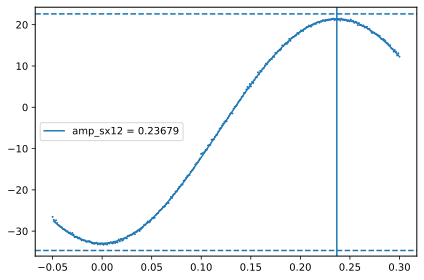

In [24]:
fig, ax = plt.subplots(ncols=1, figsize=(6,4))
amplitude_sweep_outlier = amplitude_sweep[outliers:-outliers]
ax.scatter(amplitude_sweep, real_avg_iq, s=1)
ax.plot(amplitude_sweep_outlier, yfit)
ax.axvline(amplitude_sweep_outlier[np.argmax(yfit)], label=f'amp_sx12 = {np.round(amplitude_sweep_outlier[np.argmax(yfit)], 5)}')
ax.axhline(np.real(cluster_2_mean), linestyle='--')
ax.axhline(np.real(cluster_0_mean), linestyle='--')
ax.legend()
fig.tight_layout()
fig.savefig(f'./{path}/{experiment_id}.png')

### Rabi amplitude obtained

In [132]:
sx12_params['amp'] = amplitude_sweep_outlier[np.argmax(yfit)]

print(sx12_params)

{'freq': 4677857270.602841, 'dur': 40, 'amp': np.float64(0.23678929765886286), 'beta': 0}


In [133]:
with open("./sx12_params.json", "w") as json_file:
    json.dump(sx12_params, json_file)

In [124]:
x12_params = {'freq': rough_12_freq, 'dur': dur_chosen, 'amp': amplitude_sweep_outlier[np.argmax(yfit)], 'beta': 0}

x12_params

{'freq': 4677857270.602841,
 'dur': 40,
 'amp': np.float64(0.4797979797979798),
 'beta': 0}

In [125]:
with open("./x12_params.json", "w") as json_file:
    json.dump(x12_params, json_file)

### Discriminator

In [134]:
rabi_discrim = {
    'cluster_0_mean': cluster_0_mean, 'cluster_2_mean': cluster_2_mean, 'radius_fit': radius_fit
}

with open(f"./rabi_discrim.pkl", "wb") as f:
    pickle.dump(rabi_discrim, f)